## import 

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST #Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) #set for testing purposes, please do not change! 



## generator

### generator block
* input_dim 과 output_dim을 파라미터로 받음
* linear layer 와 batch norm, ReLU 함수로 구성 

In [2]:
def gen_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

### generator 의 구조
* 4개의 generator block와 FC layer, sigmoid함수로 구성
* 28x28 해상도의 MNIST dataset 생성 
- 입력: z_dim =10
- 출력: im_dim =784 

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator,self).__init__()
        #Build the neural network
        self.gen = nn.Sequential(
            gen_block(z_dim,hidden_dim),
            gen_block(hidden_dim,hidden_dim * 2),
            gen_block(hidden_dim * 2,hidden_dim * 4),
            gen_block(hidden_dim * 4,hidden_dim * 8),
            
            nn.Linear(hidden_dim *8, im_dim),
            nn.Sigmoid()
        )
        
    def forward(self, noise):
      return self.gen(noise)

    def get_gen(self):
      return self.gen

## (3) discriminator

### (3-1) discriminator block
* input_dim 과 outpu_dim 을 parameter 로 받음
* linear layer 와 ReLU 함수로 구성

In [4]:
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2,inplace=True))

### (3-2)discriminator 의 구조

In [5]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(im_dim, hidden_dim * 4),
            discriminator_block(hidden_dim * 4, hidden_dim * 2),
            discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )
        
    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc




### (4) 기타

### (4-1) 노이즈 함수

In [6]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device = device)

### (4-2) 파라미터 셋업

In [7]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cpu'

### (4-3) 데이터 로딩

In [8]:
dataloader = DataLoader(
    MNIST(".", download=True, transform=transforms.ToTensor()),
    batch_size = batch_size,
    shuffle = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## (5) loss함수

### (5-1)optimizer

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)

### (5-2) disc loss

In [10]:
def get_disc_loss(gen,disc,criterion,real,num_images, z_dim, device):
    fake_noise = get_noise(num_images,z_dim,device=device) # z
    fake = gen(fake_noise) #G(z)
    disc_fake_pred = disc(fake.detach()) #D(G(z))
    #compare fake_pred &zero
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)                             # D(x)
    # compare real_pred & ones
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    
    return disc_loss


    

### (5-3) gen loss

In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    # compare fake_pred & ones
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    return gen_loss


## (6) Image display

In [12]:
def show_tensor_images(image_tensor, num_images = 25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow = 5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## (7) Training

step 500: Generator loss: 0.0032592294216156007, discriminator loss: 0.41958287709951464


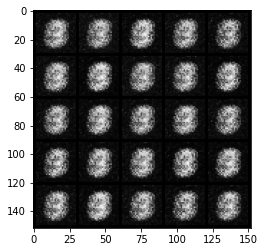

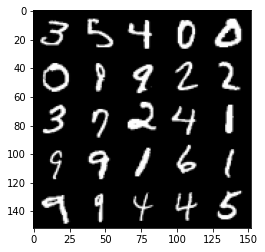

step 1000: Generator loss: 0.0037548606395721436, discriminator loss: 0.29902457961440126


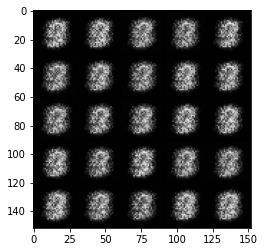

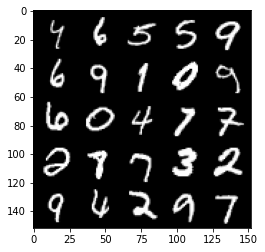

step 1500: Generator loss: 0.003974728345870972, discriminator loss: 0.17604478403925897


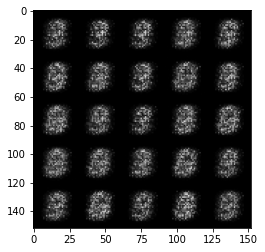

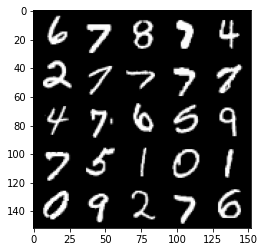

step 2000: Generator loss: 0.0033064818382263182, discriminator loss: 0.19723815432190903


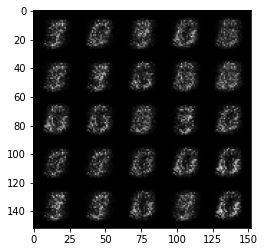

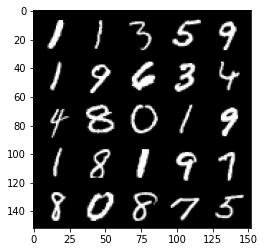

step 2500: Generator loss: 0.003769070625305176, discriminator loss: 0.19434744080901142


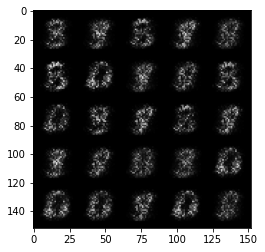

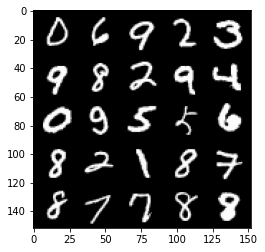

step 3000: Generator loss: 0.00397512149810791, discriminator loss: 0.14867381440103064


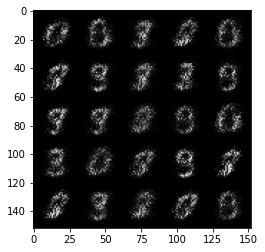

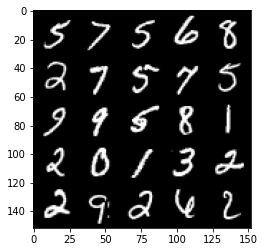

step 3500: Generator loss: 0.005207387447357178, discriminator loss: 0.12165233024954793


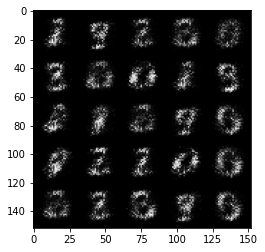

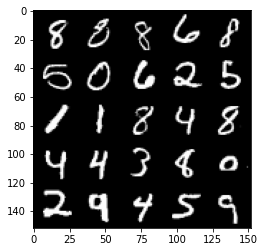

step 4000: Generator loss: 0.005763138771057129, discriminator loss: 0.12033563651144502


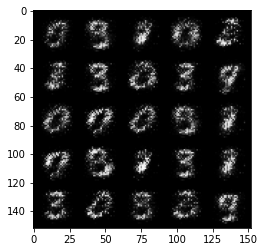

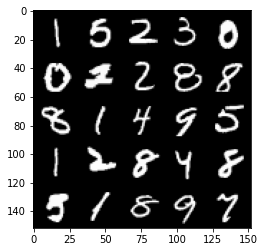

step 4500: Generator loss: 0.006400835037231445, discriminator loss: 0.10301913230121132


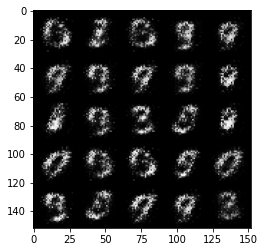

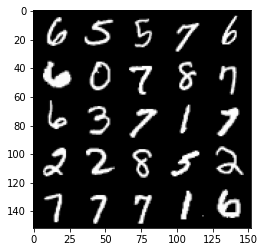

step 5000: Generator loss: 0.007227864742279053, discriminator loss: 0.08745244484394785


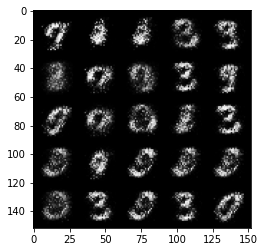

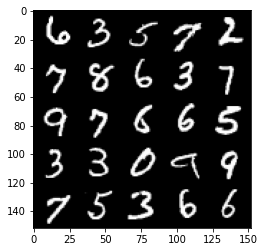

step 5500: Generator loss: 0.007568917274475098, discriminator loss: 0.08549102097749707


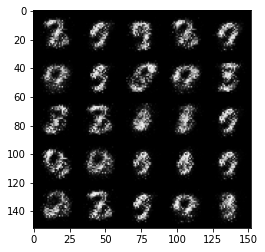

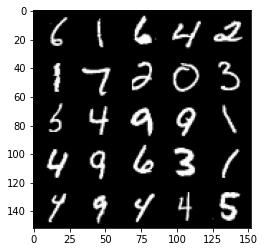

step 6000: Generator loss: 0.007838443756103515, discriminator loss: 0.07953945264220237


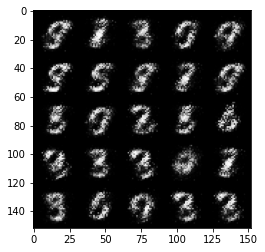

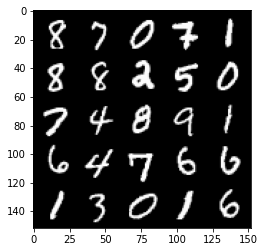

step 6500: Generator loss: 0.0072504434585571285, discriminator loss: 0.06731449716538186


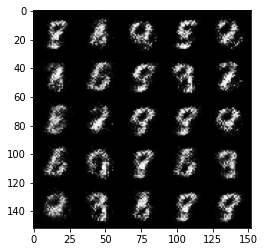

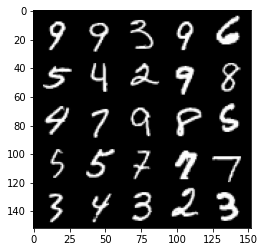

step 7000: Generator loss: 0.008662007331848144, discriminator loss: 0.04958873681351544


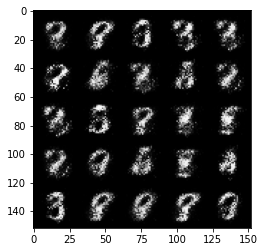

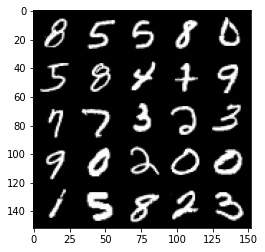

step 7500: Generator loss: 0.007930616855621337, discriminator loss: 0.04969146407395603


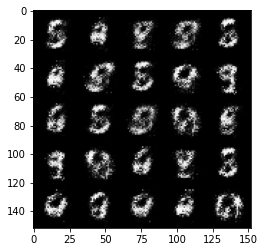

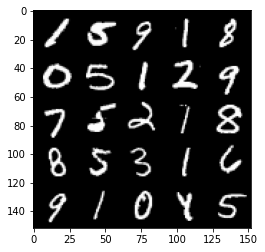

step 8000: Generator loss: 0.008822569847106934, discriminator loss: 0.061361653923988374


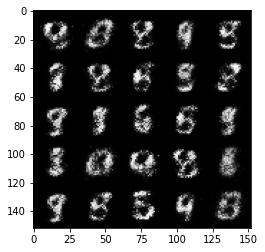

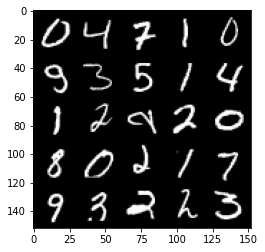

step 8500: Generator loss: 0.008109779357910156, discriminator loss: 0.08109244145452982


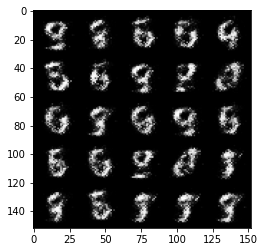

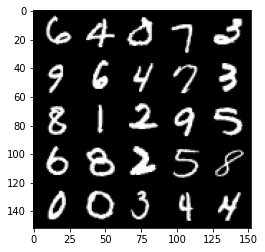

step 9000: Generator loss: 0.008587192535400391, discriminator loss: 0.05541566104441881


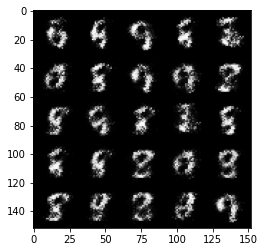

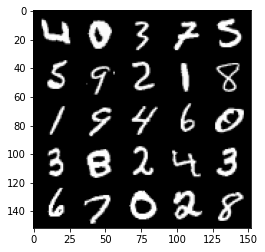

step 9500: Generator loss: 0.008201237678527831, discriminator loss: 0.06640146076679233


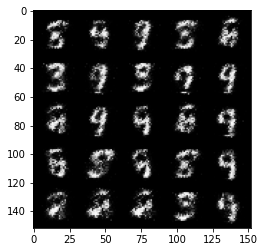

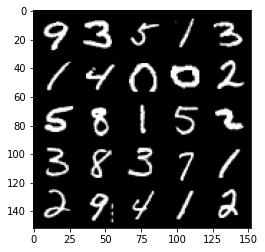

step 10000: Generator loss: 0.007536046028137207, discriminator loss: 0.06591899125277995


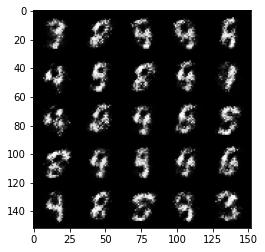

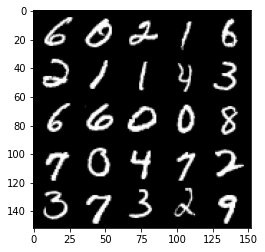

step 10500: Generator loss: 0.008987856864929198, discriminator loss: 0.059543012846261324


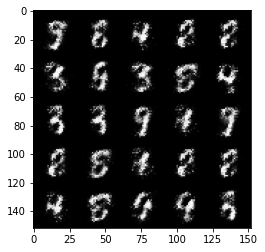

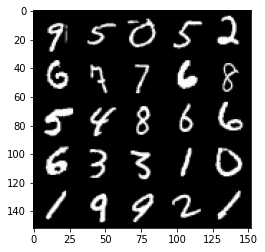

step 11000: Generator loss: 0.008699140548706054, discriminator loss: 0.06391380060091616


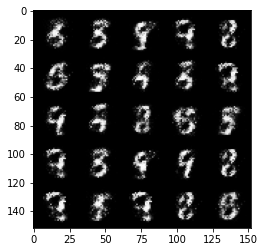

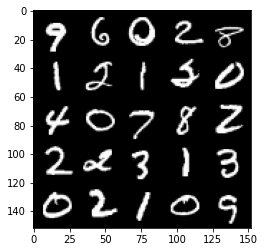

step 11500: Generator loss: 0.00828227710723877, discriminator loss: 0.06917599194496872


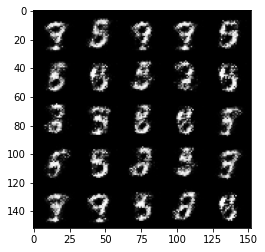

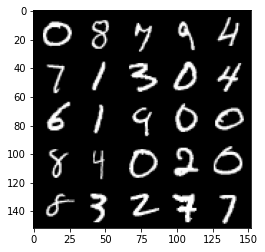

step 12000: Generator loss: 0.007729289054870606, discriminator loss: 0.07641980797052385


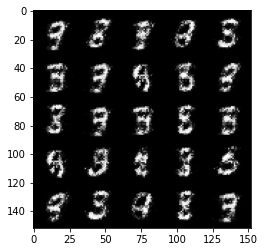

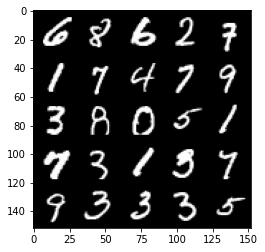

step 12500: Generator loss: 0.008612313270568848, discriminator loss: 0.07621181546896696


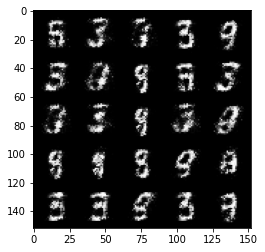

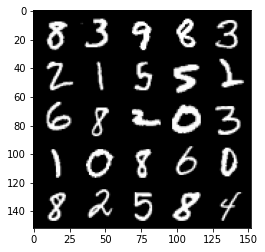

step 13000: Generator loss: 0.008654365539550781, discriminator loss: 0.07363890793919564


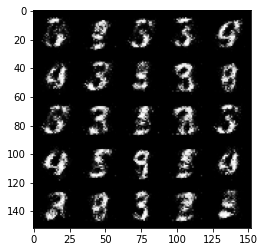

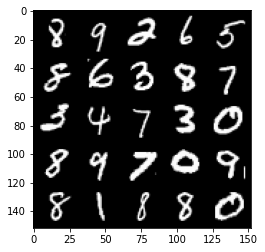

step 13500: Generator loss: 0.007971397399902344, discriminator loss: 0.08574602384865283


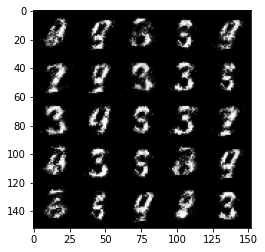

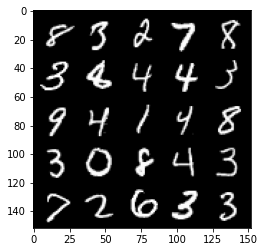

step 14000: Generator loss: 0.0080445613861084, discriminator loss: 0.08151888623088596


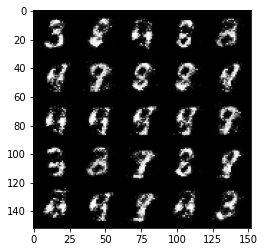

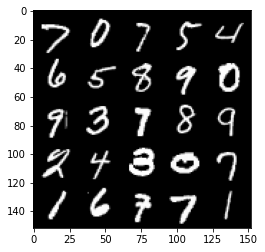

step 14500: Generator loss: 0.007761070728302002, discriminator loss: 0.08870922841876745


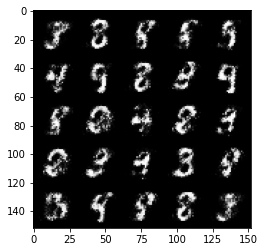

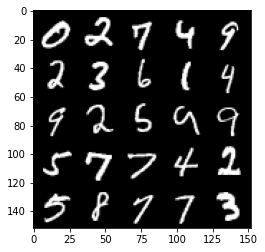

step 15000: Generator loss: 0.007597784042358399, discriminator loss: 0.10609515500813727


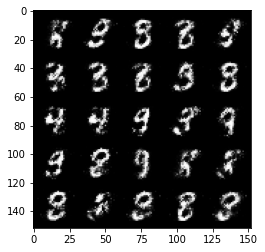

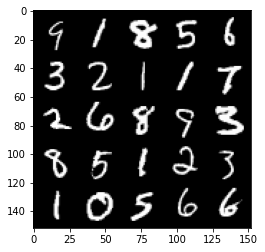

step 15500: Generator loss: 0.008164597511291503, discriminator loss: 0.10615691096335654


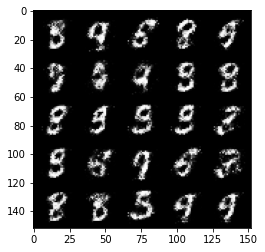

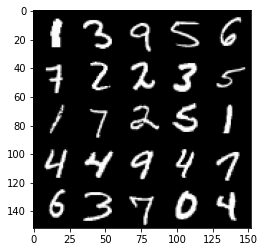

step 16000: Generator loss: 0.007490349769592285, discriminator loss: 0.10961138758063313


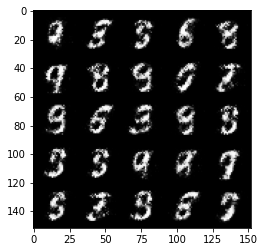

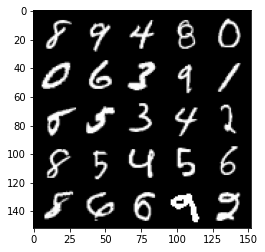

step 16500: Generator loss: 0.007711825847625732, discriminator loss: 0.10712084356695416


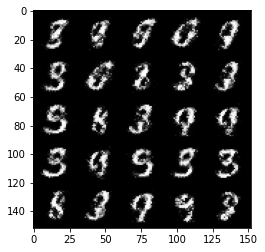

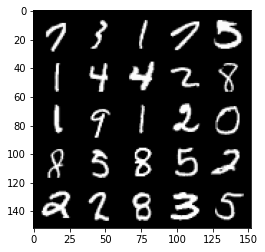

step 17000: Generator loss: 0.008063720703125, discriminator loss: 0.12400831303000463


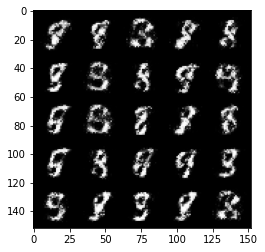

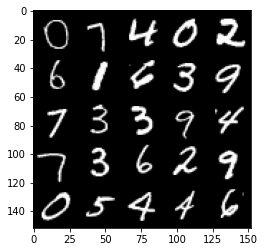

step 17500: Generator loss: 0.007709033966064453, discriminator loss: 0.15082772293686858


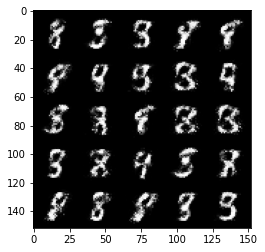

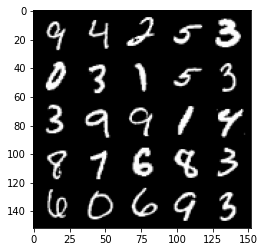

step 18000: Generator loss: 0.006569520473480224, discriminator loss: 0.14207359826564792


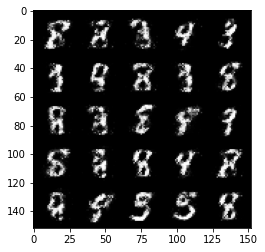

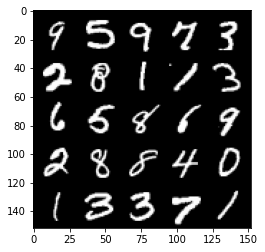

step 18500: Generator loss: 0.007209439754486084, discriminator loss: 0.13509031914174557


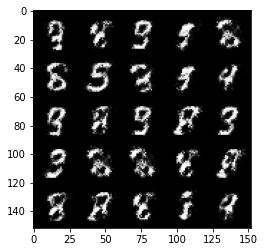

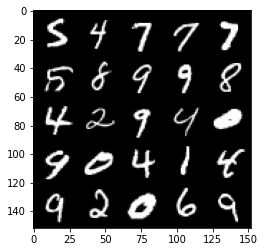

step 19000: Generator loss: 0.006701769351959229, discriminator loss: 0.13144881297647965


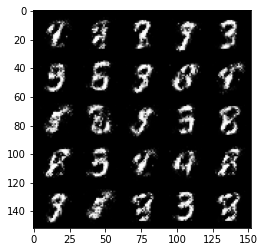

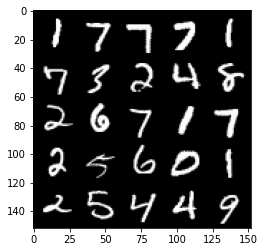

step 19500: Generator loss: 0.006398199081420898, discriminator loss: 0.16426959557831297


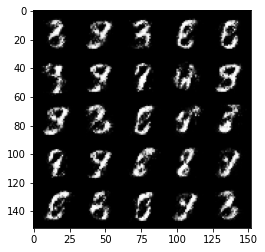

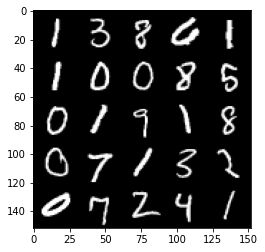

step 20000: Generator loss: 0.006508228302001953, discriminator loss: 0.16539990215003483


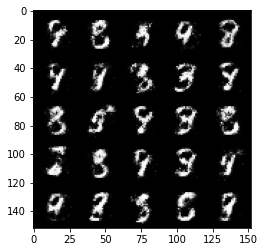

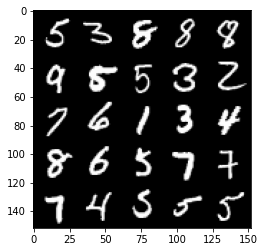

step 20500: Generator loss: 0.006060457229614258, discriminator loss: 0.16830662062764148


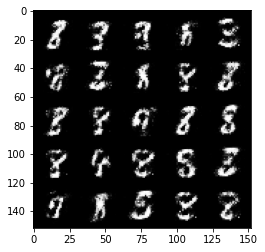

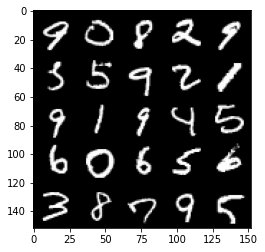

step 21000: Generator loss: 0.006579045295715332, discriminator loss: 0.1564159173965454


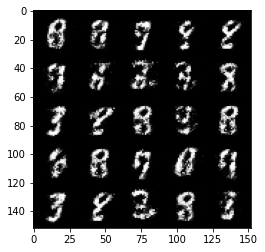

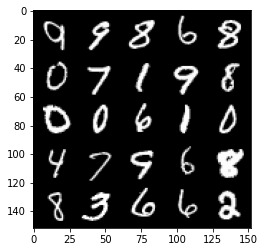

step 21500: Generator loss: 0.005679416656494141, discriminator loss: 0.17138668757677084


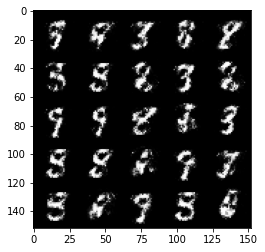

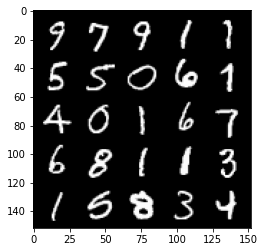

step 22000: Generator loss: 0.005816731452941894, discriminator loss: 0.1719910383373498


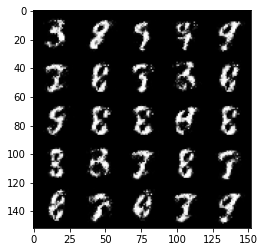

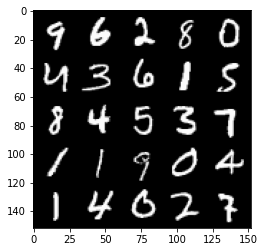

step 22500: Generator loss: 0.006428952217102051, discriminator loss: 0.17581433646380876


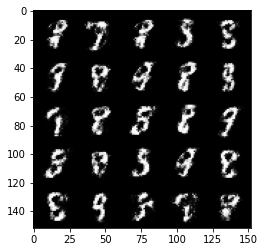

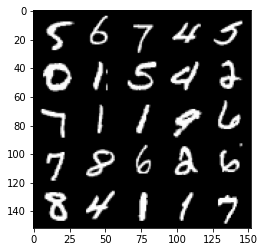

In [ ]:
cur_step =0
mean_generator_loss =0
mean_discriminator_loss=0
test_generator= True
gen_loss= False
error= False

#image_tensor = the imagesto show

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        
        # update discriminator
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim ,device)
        disc_loss.backward(retain_graph = True)
        disc_opt.step()
        
        # if test_generator:
        #     old_generator_weights=gen.gen[0][0].weight.detach().clone()

        # update generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion,cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()        
    
        # if test_generator:
        #   try:
        #     assert lr > 0.0000002 or (gen.gen[0][0].weigth.grad.abs().max()< 0.0005 and epoch == 0)
        #     assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
        #   except:
        #     error = True
        #     print("Runtime tests have failed.")
        
        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss = gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0: 
          print(f"step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
          fake_noise = get_noise(cur_batch_size , z_dim, device = device )
          fake = gen(fake_noise)
          show_tensor_images(fake)
          show_tensor_images(real)
          mean_generator_loss =0
          mean_discriminator_loss = 0
        cur_step += 1

